# Evaluate Combined dataset

In [1]:
from mol2ccs.utils import performance_evaluation
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

from utils import (
    compare_models_by_adduct,
    compare_models_dimer_and_mol_type,
)

In [2]:
pd.options.mode.copy_on_write = True

In [5]:
mol2ccs_preds = pd.read_parquet(
    "ccs-prediction-outputs/final-experiments-paper/mol2ccs/metlin_ccsbase_test_3d_pred.parquet"
)

graphccs_pred = pd.read_parquet(
    "ccs-prediction-outputs/final-experiments-paper/graphccs/v2-graphccs-combined-test-predictions.parquet"
)

sigmaccs_pred = pd.read_parquet(
    "ccs-prediction-outputs/final-experiments-paper/sigmaccs-old/results/metlin_ccsbase_test_3d_pred.parquet"
)

Ensure that the predictions are in the same order as the test set

In [7]:
mol2ccs_preds.shape[0], graphccs_pred.shape[0], sigmaccs_pred.shape[0]

(12482, 12485, 12482)

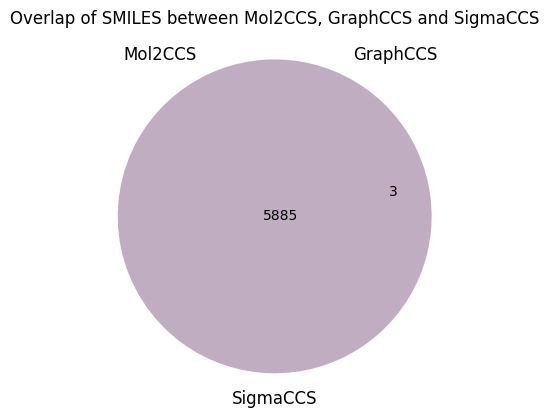

In [8]:
# Venn diagram of the three smiles
venn3(
    [
        set(mol2ccs_preds["smiles"].tolist()),
        set(graphccs_pred["SMILES"].tolist()),
        set(sigmaccs_pred["smiles"].tolist()),
    ],
    set_labels=["Mol2CCS", "GraphCCS", "SigmaCCS"],
)
plt.title("Overlap of SMILES between Mol2CCS, GraphCCS and SigmaCCS")

plt.show()

In [9]:
# Add "dimer", "mol_type", "ccs_type" to mol2ccs_preds from graphccs_pred

mol2ccs_preds["dimer"] = graphccs_pred["dimer"]
mol2ccs_preds["mol_type"] = graphccs_pred["mol_type"]
mol2ccs_preds["ccs_type"] = graphccs_pred["ccs_type"]

sigmaccs_pred["dimer"] = graphccs_pred["dimer"]
sigmaccs_pred["mol_type"] = graphccs_pred["mol_type"]
sigmaccs_pred["ccs_type"] = graphccs_pred["ccs_type"]

In [10]:
print(f"Performance metrics for Mol2CCS:\n#################################")

performance_mol2ccs, _ = performance_evaluation(
    input_pred=mol2ccs_preds["pred_ccs"],
    input_true=mol2ccs_preds["ccs"],
    output_type="dataframe",
)

print(f"\nPerformance metrics for GraphCCS:\n#################################")
performance_graphccs, _ = performance_evaluation(
    input_pred=graphccs_pred["Label"],
    input_true=graphccs_pred["predict"],
    output_type="dataframe",
)

print(f"\nPerformance metrics for SigmaCCS:\n#################################")
performance_sigmaccs, _ = performance_evaluation(
    input_pred=sigmaccs_pred["Predicted CCS"],
    input_true=sigmaccs_pred["ccs"],
    output_type="dataframe",
)

Performance metrics for Mol2CCS:
#################################
MAE : 4.41
MSE : 37.52
RMSE : 6.13
R2 : 0.95
Mean Percent RSD : 2.25
Median Percent RSD : 1.71
Max Percent RSD : 41.17
Min Percent RSD : 0.0
Pearson's correlation : 0.98
Spearman's correlation : 0.96

Performance metrics for GraphCCS:
#################################
MAE : 3.81
MSE : 30.85
RMSE : 5.55
R2 : 0.96
Mean Percent RSD : 1.93
Median Percent RSD : 1.39
Max Percent RSD : 36.8
Min Percent RSD : 0.0
Pearson's correlation : 0.98
Spearman's correlation : 0.96

Performance metrics for SigmaCCS:
#################################
MAE : 4.4
MSE : 36.54
RMSE : 6.04
R2 : 0.95
Mean Percent RSD : 2.25
Median Percent RSD : 1.7
Max Percent RSD : 34.94
Min Percent RSD : 0.0
Pearson's correlation : 0.97
Spearman's correlation : 0.95


In [11]:
# Concatenate the three performance dataframes and add a column for the method
performance = pd.concat(
    [performance_mol2ccs, performance_graphccs, performance_sigmaccs]
)
performance["method"] = (
    ["mol2ccs"] * performance_mol2ccs.shape[0]
    + ["graphccs"] * performance_graphccs.shape[0]
    + ["sigmaccs"] * performance_sigmaccs.shape[0]
)

In [12]:
performance

,Metric,Value,method
0,MAE,4.409834,mol2ccs
1,MSE,37.521057,mol2ccs
2,RMSE,6.125443,mol2ccs
3,R2,0.952296,mol2ccs
4,Mean Percent RSD,2.245182,mol2ccs
5,Median Percent RSD,1.705543,mol2ccs
6,Max Percent RSD,41.171980,mol2ccs
7,Min Percent RSD,0.000077,mol2ccs
8,Pearson's correlation,0.975857,mol2ccs
9,Spearman's correlation,0.957376,mol2ccs


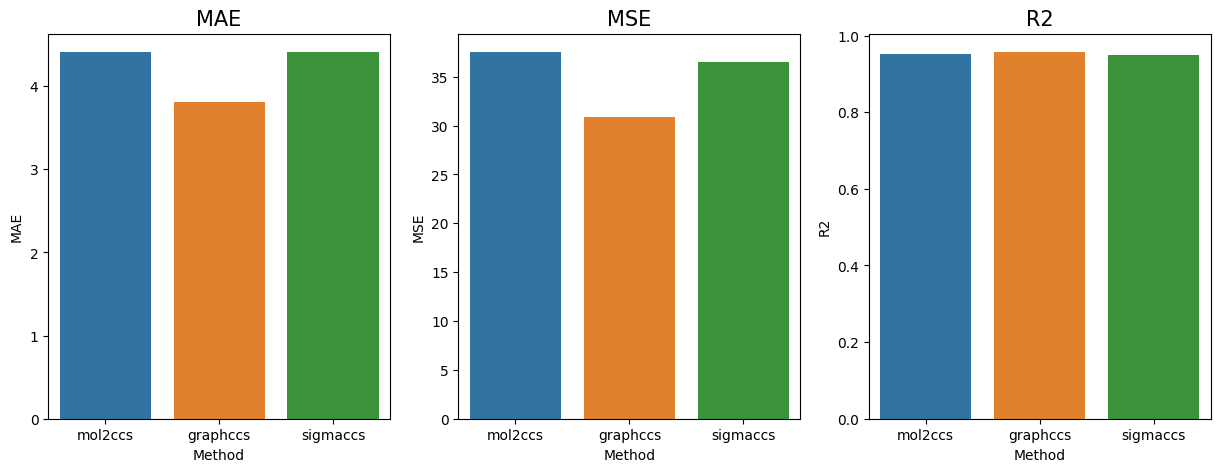

In [13]:
# Plot the performance metrics for the three methods in the same subplot using seaborn pairplor for MAE, RMSE, R2
fig = plt.figure(figsize=(15, 5))

gs = gridspec.GridSpec(1, 3)

for i, metric in enumerate(["MAE", "MSE", "R2"]):
    ax = plt.subplot(gs[0, i])

    # subset by metric
    subset = performance[performance["Metric"] == metric]

    sns.barplot(data=subset, x="method", y="Value", ax=ax, hue="method")

    ax.set_title(metric, fontsize=15)
    ax.set_xlabel("Method")
    ax.set_ylabel(metric)

# Compare models by Adduct

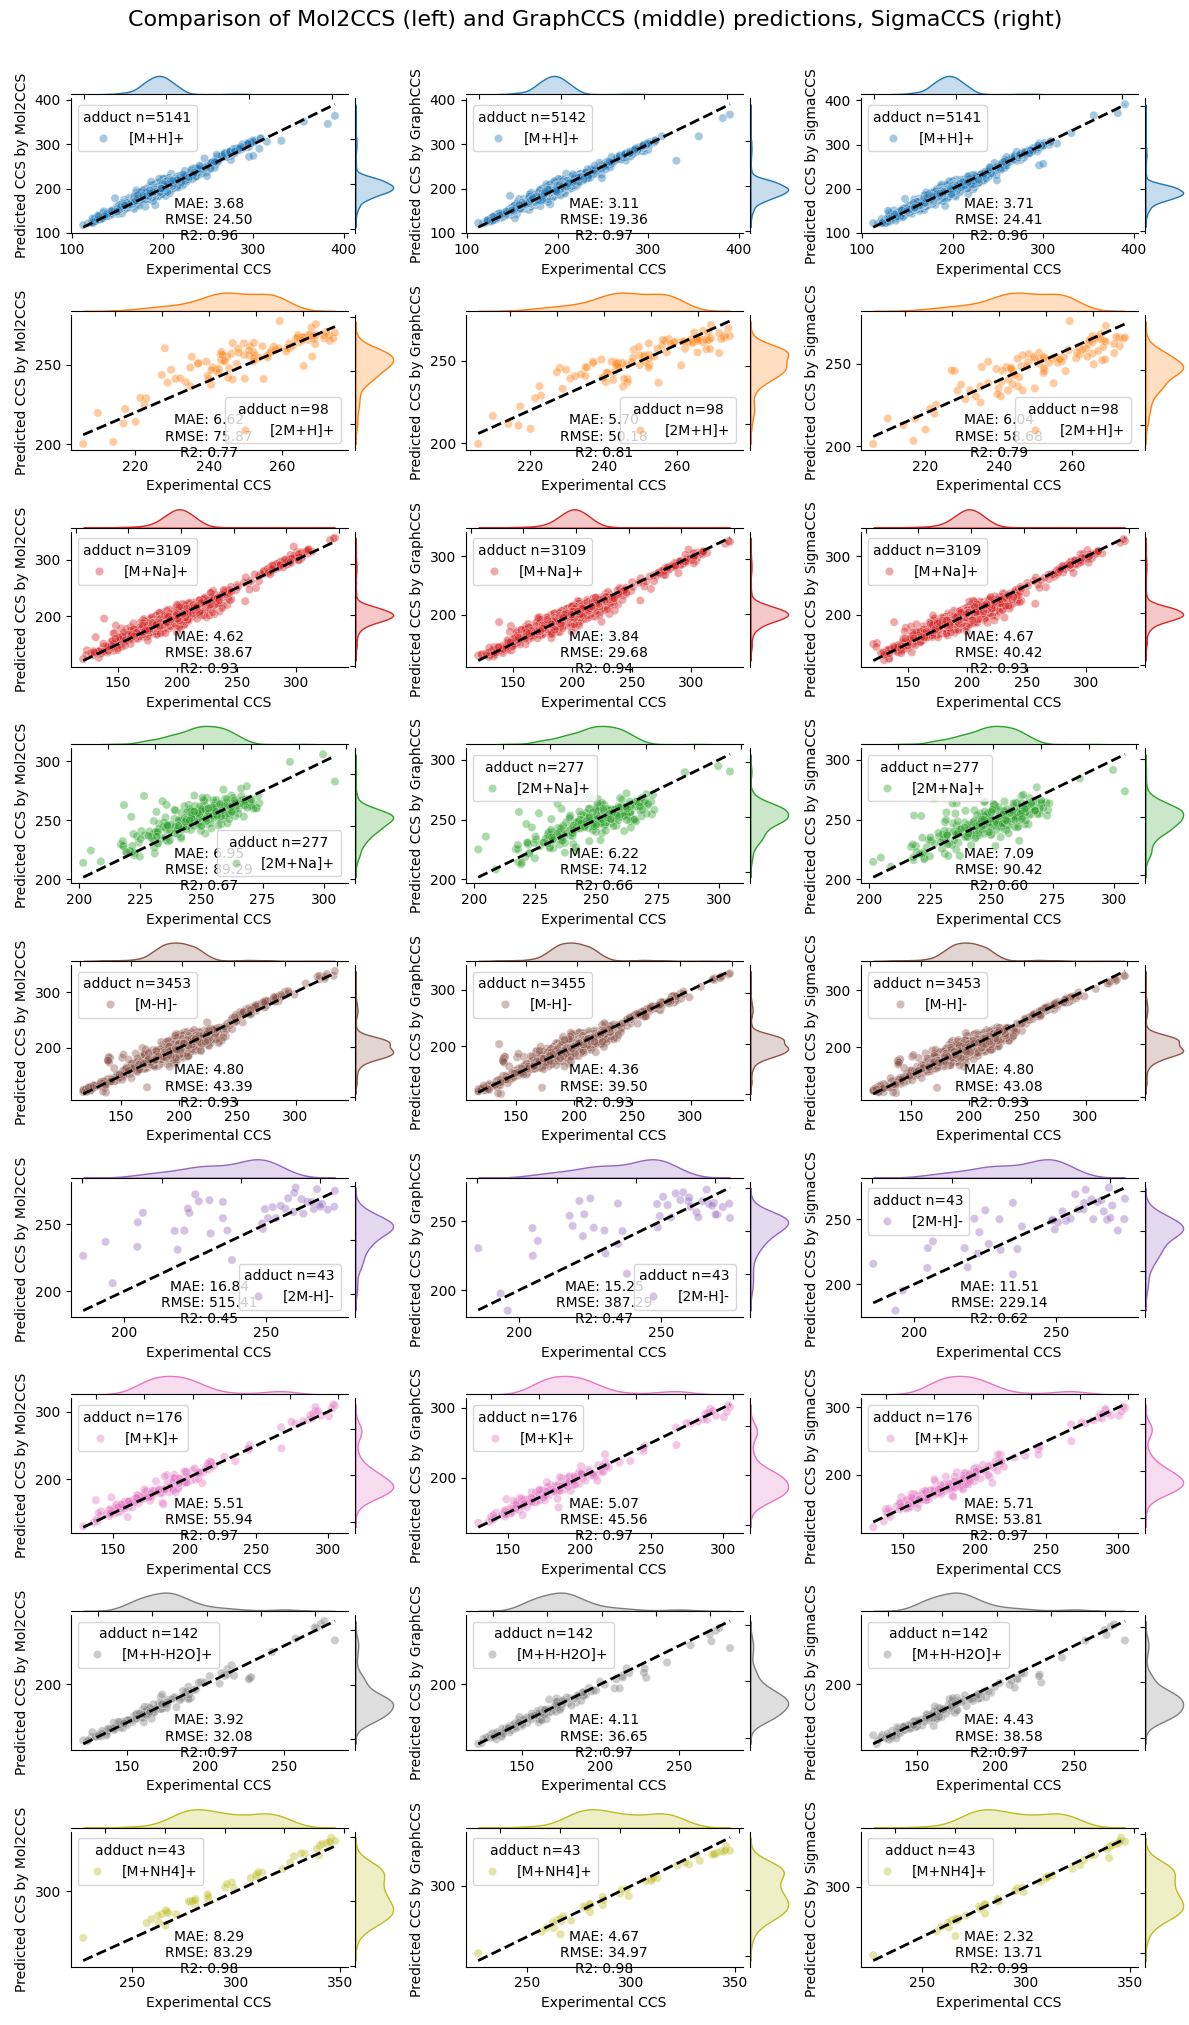

In [14]:
compare_models_by_adduct(
    model1=mol2ccs_preds,
    model2=graphccs_pred,
    model1_name="Mol2CCS",
    model1_ccs_label="ccs",
    model1_pred_ccs_label="pred_ccs",
    model1_adduct_label="adduct",
    model2_name="GraphCCS",
    model2_ccs_label="Label",
    model2_pred_ccs_label="predict",
    model2_adduct_label="Adduct",
    model3=sigmaccs_pred,
    model3_name="SigmaCCS",
    model3_ccs_label="ccs",
    model3_pred_ccs_label="Predicted CCS",
    model3_adduct_label="adduct",
)

# Compare models by Dimer/Monomer and Mol Type

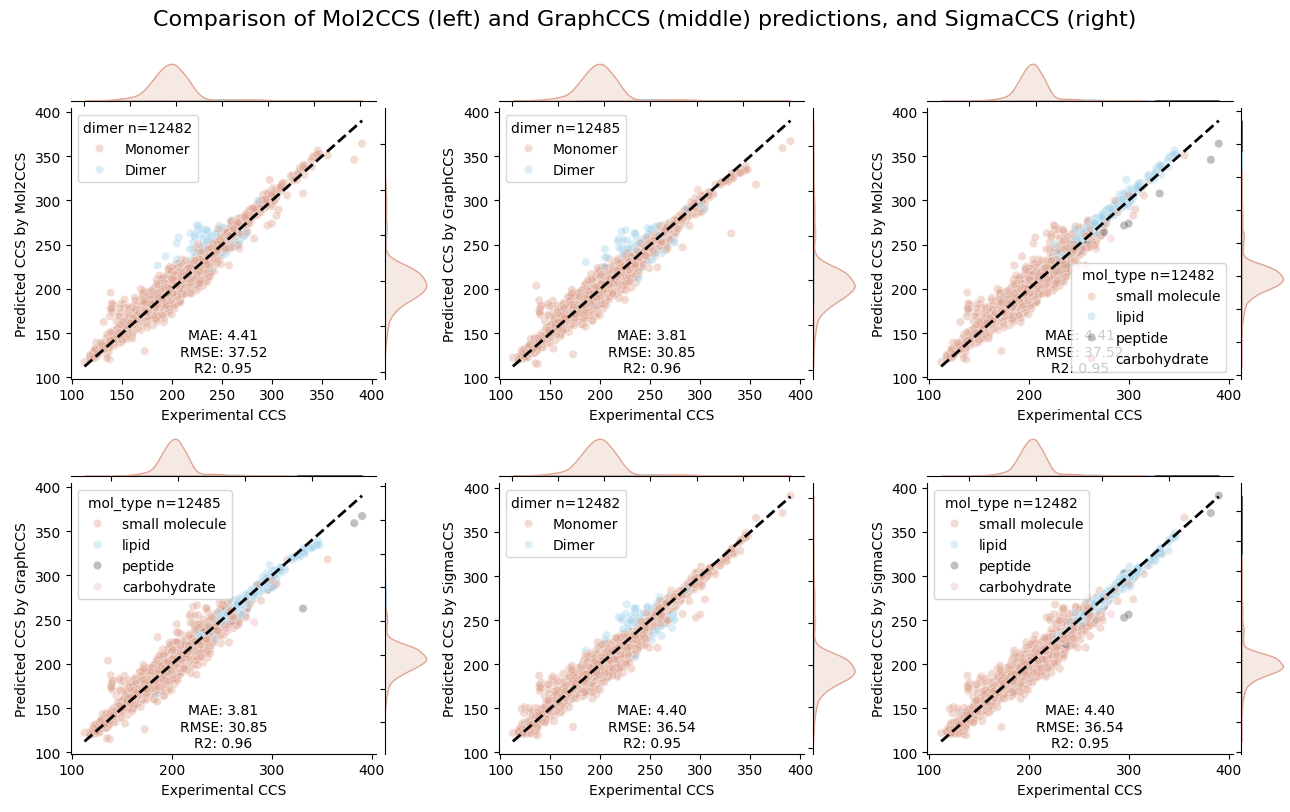

In [15]:
compare_models_dimer_and_mol_type(
    mol2ccs_preds,
    graphccs_pred,
    "Mol2CCS",
    "GraphCCS",
    model1_ccs_label="ccs",
    model1_pred_ccs_label="pred_ccs",
    model2_ccs_label="Label",
    model2_pred_ccs_label="predict",
    model3=sigmaccs_pred,
    model3_name="SigmaCCS",
    model3_ccs_label="ccs",
    model3_pred_ccs_label="Predicted CCS",
)

In [16]:
# Add a column to both dataframes indicating the difference between the predicted and experimental CCS
mol2ccs_preds["ccs_diff"] = mol2ccs_preds["pred_ccs"] - mol2ccs_preds["ccs"]
graphccs_pred["ccs_diff"] = graphccs_pred["predict"] - graphccs_pred["Label"]
sigmaccs_pred["ccs_diff"] = sigmaccs_pred["Predicted CCS"] - sigmaccs_pred["ccs"]


# sort the dataframe by the difference in CCS
mol2ccs_preds.sort_values("ccs_diff", inplace=True)
graphccs_pred.sort_values("ccs_diff", inplace=True)
sigmaccs_pred.sort_values("ccs_diff", inplace=True)

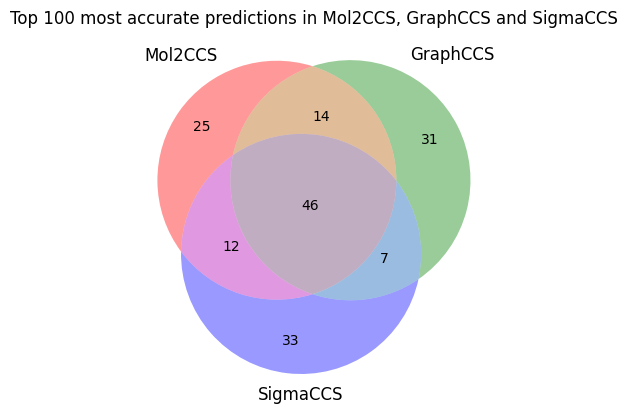

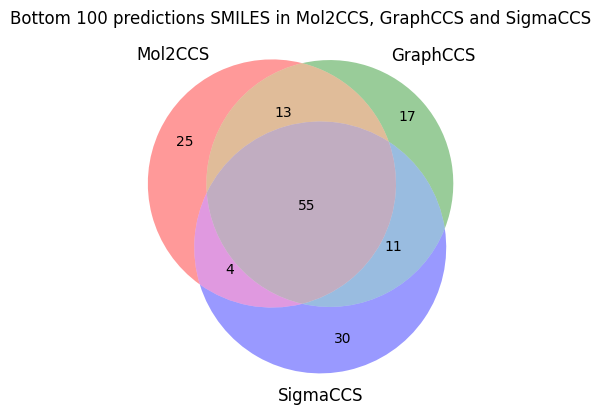

In [17]:
# make a venn diagram of the smiles in the two dataframes on top 100
venn3(
    subsets=(
        set(mol2ccs_preds["smiles"].tolist()[:100]),
        set(graphccs_pred["SMILES"].tolist()[:100]),
        set(sigmaccs_pred["smiles"].tolist()[:100]),
    ),
    set_labels=("Mol2CCS", "GraphCCS", "SigmaCCS"),
)
plt.title("Top 100 most accurate predictions in Mol2CCS, GraphCCS and SigmaCCS")

plt.show()
# same for the bottom 100

# title
venn3(
    subsets=(
        set(mol2ccs_preds["smiles"].tolist()[-100:]),
        set(graphccs_pred["SMILES"].tolist()[-100:]),
        set(sigmaccs_pred["smiles"].tolist()[-100:]),
    ),
    set_labels=("Mol2CCS", "GraphCCS", "SigmaCCS"),
)
plt.title("Bottom 100 predictions SMILES in Mol2CCS, GraphCCS and SigmaCCS")

plt.show()